# Файлы и описание данных

**assessments.csv — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).**

* `code_module` — идентификационный код предмета.
* `code_presentation` — семестр (Идентификационный код).
* `id_assessment` — тест (Идентификационный номер ассессмента).
* `assessment_type` — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
* `date` — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
* `weight` — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

**courses.csv — файл содержит список предметов по семестрам.**
* `code_module` — предмет (идентификационный код).
* `code_presentation` — семестр (идентификационный код).
* `module_presentation_length` — продолжительность семестра в днях.

**studentAssessment.csv — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.**
* `id_assessment` — тест (идентификационный номер).
* `id_student` — идентификационный номер студента.
* `date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
* `is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
* `score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

**studentRegistration.csv — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.**
* `code_module` — предмет (идентификационный код).
* `code_presentation` — семестр (идентификационный код)
* `id_student` — идентификационный номер студента.
* `date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
* `date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [2]:
#Загрузка необходимых библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import urllib.parse
import requests

%matplotlib inline

In [3]:
# Загрузка данных

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_1 = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'  
public_key_2 = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
public_key_3 = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'  
public_key_4 = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw' 
 
# Получение загрузочных ссылкок

final_url_1 = base_url + urllib.parse.urlencode(dict(public_key=public_key_1)) 
response = requests.get(final_url_1) 
download_url_1 = response.json()['href'] 

final_url_2 = base_url + urllib.parse.urlencode(dict(public_key=public_key_2)) 
response = requests.get(final_url_2) 
download_url_2 = response.json()['href'] 

final_url_3 = base_url + urllib.parse.urlencode(dict(public_key=public_key_3)) 
response = requests.get(final_url_3) 
download_url_3 = response.json()['href'] 

final_url_4 = base_url + urllib.parse.urlencode(dict(public_key=public_key_4)) 
response = requests.get(final_url_4) 
download_url_4 = response.json()['href'] 

# Загрузка данных в датафреймы

assessments = pd.read_csv(download_url_1)  #оценки за тесты
courses = pd.read_csv(download_url_2)      #список предметов по семестрам 
results = pd.read_csv(download_url_3)      #результаты тестов студентов
registration = pd.read_csv(download_url_4) #время зарегистрирации на курс 

### Прежде, чем приступить к решению задачи, я провела предварительное исследование данных и сформулировала, что должно считаться курсом.

In [4]:
# Список предметов и семестров, по которым студенты сдавали экзамены

# Объединение таблиц results (результаты тестов студентов) и assessments (информация об оценках за тесты)
results_with_assessments = results.merge(assessments, how = 'inner', on='id_assessment')

# Рассчет количества студентов, которые сдавали тесты типа "Exam"
courses = results_with_assessments.query("assessment_type == 'Exam' and is_banked == 0") \
                                  .groupby(['code_module', 'code_presentation'], as_index = False) \
                                  .agg({'id_student': 'count'}) 
courses

code_module code_presentation  id_student
0         CCC             2014B         747
1         CCC             2014J        1168
2         DDD             2013B         602
3         DDD             2013J         968
4         DDD             2014B         524
5         DDD             2014J         950

Определение количества студентов, которые сдавали экзамен по предмету CCC или DDD больше, чем в одном семестре

In [4]:
exam_CCC = results_with_assessments.query("code_module == 'CCC' and assessment_type == 'Exam' and is_banked == 0") \
    .groupby('id_student', as_index=False) \
    .agg({'code_module': 'count', 'code_presentation': 'count'}) \
    .sort_values('code_module') \
    .query("code_module > 1") \
    .count()

print(exam_CCC[0], 'студентов сдавали экзамен по предмету CCC больше, чем в одном семестре ')

0 студентов сдавали экзамен по предмету CCC больше, чем в одном семестре 


In [5]:
exam_DDD = results_with_assessments.query("code_module == 'DDD' and assessment_type == 'Exam' and is_banked == 0") \
    .groupby('id_student', as_index=False) \
    .agg({'code_module': 'count', 'code_presentation': 'count'}) \
    .sort_values('code_module') \
    .query("code_module > 1") \
    .count()

print(exam_DDD[0], 'студента сдавали экзамен по предмету DDD больше, чем в одном семестре ')

4 студента сдавали экзамен по предмету DDD больше, чем в одном семестре 


<i>**В качестве курса считаю каждый семестр предметов CCC и DDD, так как по этим предметам студенты сдавали экзамены и количество студентов, которые посетили больше одного семестра, незначительно.**</i>

**1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)**

In [6]:
# Выбираем тесты с типом "Exam" и успешной сдачей (больше 40 баллов)

exam = results_with_assessments.query("assessment_type == 'Exam' and score >= 40 and is_banked == 0") \
                        .groupby(['id_student'], as_index=False) \
                        .agg({'date_submitted': 'count'}) \
                        .query('date_submitted == 1') \
                        .count()

print(exam[0], 'студента успешно сдали только 1 курс')

3802 студента успешно сдали только 1 курс


**2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью. (Завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен)**

In [7]:
# Расчет количества пройденных тестов типа "Exam"
count_exam = results_with_assessments.query("assessment_type == 'Exam' and is_banked == 0") \
                        .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
                        .agg({'date_submitted': 'count'}) \
                        .rename(columns={'date_submitted': 'Exam'})

# Расчет количества успешно сданных тестов типа "Exam"
count_success = results_with_assessments.query("assessment_type == 'Exam' and score >= 40 and is_banked == 0") \
                        .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
                        .agg({'date_submitted': 'count'}) \
                        .rename(columns={'date_submitted': 'Exam_success'})

# Объединение таблиц
total_count = count_success.merge(count_exam, how='inner', on=['code_module', 'code_presentation', 'id_assessment'])

# Расчет завершаемости курсов 
total_count['complete'] = ((count_success.Exam_success/count_exam.Exam)*100).round(2)

hard_exam = total_count.sort_values('complete').reset_index()
easy_exam = total_count.sort_values('complete', ascending=False).reset_index()

hard_list = hard_exam.loc[0, :].values.flatten().tolist()
easy_list = easy_exam.loc[0, :].values.flatten().tolist()

print('Самый сложный экзамен:', 'ID теста -', hard_list[3], ', предмет -', hard_list[1], ', семестр -', hard_list[2],
      '\nСамый простой экзамен:', 'ID теста -', easy_list[3], ', предмет -', easy_list[1], ', семестр -', easy_list[2])

Самый сложный экзамен: ID теста - 25340 , предмет - DDD , семестр - 2013B 
Самый простой экзамен: ID теста - 25361 , предмет - DDD , семестр - 2014B


**3. По каждому предмету определи средний срок сдачи экзаменов 
(под сдачей понимаем последнее успешное прохождение экзамена студентом).**

In [8]:
# Для расчета среднего срока сдачи экзамена отбираем максимальное количество дней успешно сданного теста типа "Exam" 
# для каждого курса 

df_3 = results_with_assessments.query("assessment_type == 'Exam' and score >= 40 and is_banked == 0") \
                        .groupby(['id_student', 'code_module'], as_index=False) \
                        .agg({'date_submitted':'max'}) \
                        .groupby('code_module', as_index = False) \
                        .agg({'date_submitted': 'mean'}) \
                        .rename(columns={'date_submitted': 'mean_date'})

df_3['mean_date'] = df_3.mean_date.apply(lambda x: round(x, 0))

print('Для предмета CCC средний срок сдачи экзамена:', df_3.mean_date[0], 
      '\nДля предмета DDD средний срок сдачи экзамена:', df_3.mean_date[1])

Для предмета CCC средний срок сдачи экзамена: 239.0 
Для предмета DDD средний срок сдачи экзамена: 238.0


**4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).**

In [9]:
# Удаление данных с пропущенной датой регистрации 
registration.dropna(subset=['date_registration'], inplace=True) 

# Определение топ-3 предмета, на которые зарегистрировалось большее количество студентов
reg_top_3 = registration.groupby('code_module', as_index=False) \
                        .agg({'id_student': 'nunique'}) \
                        .rename(columns={'id_student':'count_student'}) \
                        .nlargest(3, 'count_student', keep='all')

# Определение топ-3 предмета, на которые отменили регистрацию большее количество студентов
unreg_top_3 = registration.query("date_unregistration != 'NaN'") \
                          .groupby('code_module', as_index=False) \
                          .agg({'id_student': 'nunique'}) \
                          .rename(columns={'id_student':'count_student'}) \
                          .nlargest(3, 'count_student', keep='all')

print('Топ-3 предмета по количеству регистраций:', *reg_top_3['code_module'].to_list(),
     '\nТоп-3 предмета с самым большим оттоком:', *unreg_top_3['code_module'].to_list())

Топ-3 предмета по количеству регистраций: BBB FFF DDD 
Топ-3 предмета с самым большим оттоком: BBB FFF DDD


**5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой 
завершаемостью курсов и самыми долгими средними сроками сдачи курсов.**

In [10]:
# Для расчета среднего срока сдачи экзамена отбираем максимальное количество дней успешно сданного теста типа "Exam" 
# для каждого курса 
date_exam = results_with_assessments.query("assessment_type == 'Exam' and score >= 40") \
                                    .groupby(['code_module', 'code_presentation'], as_index=False) \
                                    .agg({'date_submitted': 'mean'}) \
                                    .rename(columns={'date_submitted': 'mean_date'})
                        
date_exam['mean_date'] = date_exam.mean_date.apply(lambda x: round(x, 0))

# Расчет количества пройденных тестов типа "Exam"
total_exam = results_with_assessments.query("assessment_type == 'Exam'") \
                                     .groupby(['code_module', 'code_presentation'], as_index=False) \
                                     .agg({'date_submitted': 'count'}) \
                                     .rename(columns={'date_submitted': 'Exam'})

# Расчет количества успешно сданных тестов типа "Exam"
success_exam = results_with_assessments.query("assessment_type == 'Exam' and score >= 40") \
                                       .groupby(['code_module', 'code_presentation'], as_index=False) \
                                       .agg({'date_submitted': 'count'}) \
                                       .rename(columns={'date_submitted': 'Exam_success'})
# Объединение таблиц
exam = total_exam.merge(success_exam , how = 'inner', on = ['code_module', 'code_presentation'])

complete_exam = date_exam.merge(exam, how = 'inner', on = ['code_module', 'code_presentation'])

# Расчет завершаемости курсов 
complete_exam['complete'] = ((success_exam .Exam_success/total_exam.Exam)*100).round(2)

presentation_min_complete = complete_exam.nsmallest(1, 'complete', keep='all')['code_presentation'].to_list()
presentation_long_date = complete_exam.nlargest(1, 'mean_date', keep='all')['code_presentation'].to_list()

print('Семестр с самой низкой завершаемостью курсов:', *presentation_min_complete,
      '\nСеместр с самыми долгими средними сроками сдачи курсов:', *presentation_long_date)

Семестр с самой низкой завершаемостью курсов: 2013B 
Семестр с самыми долгими средними сроками сдачи курсов: 2014J


**6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, 
построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации 
можешь выбрать следующие метрики:** 
* R - среднее время сдачи одного экзамена, 
* F - завершаемость курсов, 
* M - среднее количество баллов, получаемое за экзамен. 

**Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик 
recency, frequency и monetary для интерпретации этих кластеров.**

In [11]:
#recency - среднее время сдачи одного экзамена

mean_time = results_with_assessments.query("assessment_type == 'Exam' and score >= 40") \
                                  .groupby('id_student', as_index=False) \
                                  .agg({'date_submitted': 'mean'}) \
                                  .rename(columns={'date_submitted': 'recency'})

mean_time['recency'] = mean_time.recency.apply(lambda x: round(x, 0))
mean_time.head()

id_student  recency
0       23698    243.0
1       24213    236.0
2       27116    243.0
3       28046    237.0
4       28787    243.0

In [12]:
#frequency - завершаемость курсов

count_exam = results_with_assessments.query("assessment_type == 'Exam'") \
                        .groupby('id_student', as_index=False) \
                        .agg({'id_assessment': 'count'}) \
                        .rename(columns={'id_assessment': 'Exam'})

success_exam = results_with_assessments.query("assessment_type == 'Exam' and score >= 40") \
                        .groupby('id_student', as_index=False) \
                        .agg({'id_assessment': 'count'}) \
                        .rename(columns={'id_assessment': 'Exam_success'})

complete = success_exam.merge(count_exam, how = 'inner', on = 'id_student')
complete['frequency'] = ((complete.Exam_success/complete.Exam)*100).round(2)
complete.head()

id_student  Exam_success  Exam  frequency
0       23698             1     1      100.0
1       24213             1     1      100.0
2       27116             1     1      100.0
3       28046             1     1      100.0
4       28787             1     1      100.0

In [13]:
#monetary - среднее количество баллов, получаемое за экзамен

mean_score = results_with_assessments.query("assessment_type == 'Exam'") \
                        .groupby('id_student', as_index=False) \
                        .agg({'score': 'mean'}) \
                        .rename(columns={'score': 'monetary'})

mean_score['monetary'] = mean_score.monetary.apply(lambda x: round(x, 0))
mean_score.head()

id_student  monetary
0       23698      80.0
1       24213      58.0
2       27116      96.0
3       28046      40.0
4       28787      44.0

In [14]:
# Объединение полученных таблиц

RFM = mean_score.merge(complete, how='left', on='id_student') \
                .merge(mean_time, how='left', on='id_student') \
                [['id_student', 'recency', 'frequency', 'monetary']]
RFM = RFM.fillna(0)
RFM.head()

id_student  recency  frequency  monetary
0       23698    243.0      100.0      80.0
1       24213    236.0      100.0      58.0
2       27116    243.0      100.0      96.0
3       28046    237.0      100.0      40.0
4       28787    243.0      100.0      44.0

**Создание рангов для Recency**

In [26]:
# Определение deadline для курсов 

deadline = assessments.query("code_module in ['CCC', 'DDD'] and assessment_type == 'Exam'")['date'].to_list()
print(deadline)

# deadline указан не для всех курсов

[nan, nan, nan, nan, 240.0, 261.0, 241.0, nan]


In [15]:
# Распределение среднего срока сдачи экзаменов

sns.histplot(RFM['recency'], binwidth=15)
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Recency', fontsize = 12)

#Как видно из графика - большая часть студентов сдает экзамены в районе 250 дней

Text(0.5, 0, 'Recency')

In [41]:
# Для определения даты deadline рассчитаем моду
date_mode = RFM.recency.mode()

print(date_mode[0], 'deadline для сдачи тестов типа "Exam"')

244.0 deadline для сдачи тестов типа "Exam"


In [42]:
# Зададим ранги для Recency 
# 5 - сдали экзамен до deadline (0 < R <= 244)
# 3 - сдали экзамен после deadline (R > 244)
# 1 - не сдали экзамен (R = 0)
      
def r_score(x):
    if 0 < x <= 244:
        return 5
    elif x > 244:
        return 3
    else:
        return 1
    
RFM['R'] = RFM['recency'].apply(lambda x: r_score(x))

In [43]:
# Определение процента студентов, которые сдают экзамен до deadline
R_5 = RFM.query("R == '5'").id_student.count()/RFM.id_student.count()*100
round(R_5,1)
print(round(R_5,1), 'Процент студентов, которые сдают экзамен до deadline')

83.5 Процент студентов, которые сдают экзамен до deadline


**Создание рангов для Frequency**

In [16]:
# Распределение завершаемости курсов

sns.histplot(RFM['frequency'])
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)

Text(0.5, 0, 'Frequency')

In [27]:
#Расчет количества студентов по проценту завершаемости курсов (Frequency)
RFM.frequency.value_counts()

100.0    4069
0.0       536
50.0       28
Name: frequency, dtype: int64

In [28]:
# Зададим ранги для Frequency:
# 5 - завершаемость курсов 100%
# 3 - завершаемость курсов 50%
# 1 - завершаемость курсов 0%

def f_score(x):
    if x == 0:
        return 1
    elif x == 50:
        return 3
    else:
        return 5 

RFM['F'] = RFM['frequency'].apply(lambda x: f_score(x))

In [30]:
# Определение процента студентов, которые завершают все курсы
F_5 = RFM.query("F == '5'").id_student.count()/RFM.id_student.count()*100
round(F_5,1)
print(round(F_5,1), 'Процент студентов, которые завершают все курсы')

87.8 Процент студентов, которые завершают все курсы


**Создание рангов для Monetary**

Text(0.5, 0, 'Monetary')

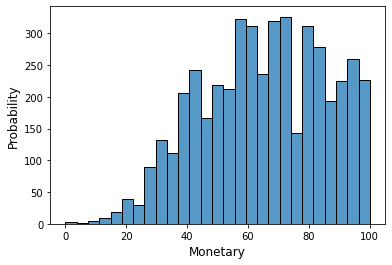

In [17]:
# Распределение средней оценки за экзамен

sns.histplot(RFM['monetary'])
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Monetary', fontsize = 12)

In [52]:
# Зададим ранги для Monetary используем пятибальную шкалу:
# 5 - экзамен сдан отлично M >= 80
# 4 - экзамен сдан хорошо  60 =< M < 80
# 3 - экзамен сдан удовлетворительно  40 =< M < 60
# 2 - экзамен не сдан  20 =< M < 40
# 1 - экзамен не сдан M < 20
 
def m_score(x):
    if x < 20:
        return 1
    elif 20 <= x < 40:
        return 2
    elif 40 <= x < 60:
        return 3
    elif 60 <= x < 80:
        return 4
    else:
        return 5 

RFM['M'] = RFM['monetary'].apply(lambda x: m_score(x))

In [53]:
RFM = RFM.astype({'R':'string', 'F':'string', 'M':'string'})

#Создание столбца с общей RFM оценкой 
RFM['RFM_Score'] = RFM['R'] + RFM['F'] + RFM['M']
RFM.head()

id_student  recency  frequency  monetary  R  F  M RFM_Score
0       23698    243.0      100.0      80.0  5  5  5       555
1       24213    236.0      100.0      58.0  5  5  3       553
2       27116    243.0      100.0      96.0  5  5  5       555
3       28046    237.0      100.0      40.0  5  5  3       553
4       28787    243.0      100.0      44.0  5  5  3       553

In [54]:
#Прежде, чем разделить стедунтов на сегменты, посмотрим какие варианты RFM комбинаций получились
RFM_segments = RFM.groupby('RFM_Score', as_index=False) \
                  .agg({'id_student':'count'}) \
                  .sort_values('RFM_Score')
RFM_segments

RFM_Score  id_student
0       111          36
1       112         500
2       353          55
3       354          77
4       355          97
5       532           7
6       533          21
7       553        1186
8       554        1438
9       555        1216

In [57]:
# Создание словаря, который содержит правила для разделения студентов на сегменты

segment_map = {
    r'11[1-2]': 'Нужна помощь',
    r'353': 'Не напрягаются',
    r'354': 'Потенциальные хорошисты',
    r'355': 'Потенциальные отличники',
    r'532': 'Не готовились',
    r'5[3-5]3': 'Оценки не важны',
    r'554': 'Хорошисты',
    r'555': 'Отличники'
}

# Создание колонки, содержащей название сегмента 
RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segment_map, regex=True)
RFM.head()

id_student  recency  frequency  monetary  R  F  M RFM_Score  \
0       23698    243.0      100.0      80.0  5  5  5       555   
1       24213    236.0      100.0      58.0  5  5  3       553   
2       27116    243.0      100.0      96.0  5  5  5       555   
3       28046    237.0      100.0      40.0  5  5  3       553   
4       28787    243.0      100.0      44.0  5  5  3       553   

           Segment  
0        Отличники  
1  Оценки не важны  
2        Отличники  
3  Оценки не важны  
4  Оценки не важны

In [58]:
# Расчет количества студентов в каждом сегменте, а также процента сегмента от общего числа студентов. 

segmentation = RFM.groupby('Segment', as_index=False)  \
                .agg({'id_student':'count'}) \
                .rename(columns={'id_student':'count_student'}) \
                .sort_values('count_student', ascending=False)

segmentation['percent_student'] = round((segmentation['count_student']/segmentation['count_student'].sum()*100),2)
segmentation = segmentation.astype({'percent_student': 'str'})  
segmentation['percent_student'] = segmentation['percent_student'].apply(lambda x: x + '%')
segmentation

Segment  count_student percent_student
7                Хорошисты           1438          31.04%
3                Отличники           1216          26.25%
4          Оценки не важны           1207          26.05%
2             Нужна помощь            536          11.57%
5  Потенциальные отличники             97           2.09%
6  Потенциальные хорошисты             77           1.66%
1           Не напрягаются             55           1.19%
0            Не готовились              7           0.15%

In [59]:
# Построение диаграммы распределения сегментов

fig = px.treemap(segmentation, path=['Segment', 'percent_student'], values='count_student')
fig.update_layout(title="Tree map of Segments", width=1000, height=800)
fig.show()

## Сегменты

Для разделения студентов на сегменты я руководствовалась следующими наблюдениями:
* большая часть студентов заканчивают все курсы <i>(у 87.8% студентов Frequency = 100%)</i>, соответственно это не очень значимый параметр
* также большая часть студентов сдают экзамены до deadline <i>(у 83.5% студентов Recency меньше 244 дней)</i>. В описании данных нет информации о том, что происходит в том случае, когда студент сдает экзамен после deadline. Так как есть студенты, получившие высокие баллы за экзамен после deadline, предположу что он носит рекомендательный характер.
* самый важный критерий для разделения на сегменты - это средняя оценка за экзамен <i>(Monetary)</i>

<hr>
    
**Границы RFM-сегментов**

|RFM_Score|Segment|Description_intervals
|:-----:|:-------:|:------|
|11[1-2]|Нужна помощь|**R**: 0 дней, **F**: 0 %, **M**: от 0 до 40 баллов|
|353|Не напрягаются|**R**: от 245 дней, **F**: 100 %, **M**: от 40 до 59 баллов|
|354|Потенциальные хорошисты|**R**: от 245 дней, **F**: 100 %, **M**: от 60 до 79 баллов|
|355|Потенциальные отличники|**R**: от 245 дней, **F**: 100 %, **M**: от 80 до 100 баллов|
|532|Не готовились|**R**: от 1 до 244 дней, **F**: 50 %, **M**: от 20 до 39 баллов|
|5[3-5]3|Оценки не важны|**R**: от 1 до 244 дней, **F**: от 50% до 100%, **M**: от 40 до 59 баллов|
|554|Хорошисты|**R**: от 1 до 244 дней, **F**: 100%, **M**: от 60 до 79 баллов|
|555|Отличники|**R**: от 1 до 244 дней, **F**: 100%, **M**: от 80 до 100 баллов|

**R** - среднее время сдачи экзаменов

**F** - завершаемость курсов

**M** - среднее количество баллов за экзамены

<hr>
   

**Описание RFM-сегментов**
    
|RFM_Score|Segment|Description|Advices
|:-----:|:-------:|:------|:------| 
|11[1-2]|Нужна помощь|Не закончили ни одного курса|Предложить тест на профориентацию для выбора других курсов. Следить за баллами по промежуточным тестам и во время предложить дополнительные материалы и задания|
|353|Не напрягаются|Сдают экзамен после deadline на оценку «3»|Нуждаются в дополнительной мотивации для получения более высоких баллов|
|354|Потенциальные хорошисты|Сдают экзамен после deadline на оценку «4»|Дать возможность изменять deadline по индивидуальному запросу|
|355|Потенциальные отличники|Сдают экзамен после deadline на оценку «5»|Дать возможность изменять deadline по индивидуальному запросу|
|532|Не готовились|Стараются сдать экзамен до deadline, но не преодолевают порог в 40 баллов|Следить за баллами по промежуточным тестам и во время предложить дополнительные материалы и задания|
|5[3-5]3|Оценки не важны|Заканчивают курсы, сдают экзамены во время на оценку «3»|Следить за баллами по промежуточным тестам, предлагать дополнительные задания для более качественной подготовки к экзамену|
|554|Хорошисты|Заканчивают все курсы, сдают все экзамены до deadline на оценку «4»|Предложить скидку на следующий курс и дополнительные задания для подготовки на "отлично"|
|555|Отличники|Заканчивают все курсы, сдают все экзамены до deadline на оценку «5»|Предложить скидку на следующий курс|


